In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore")

In [10]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [11]:
#display all columns and rows
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

### 1. Clustering with the Iris Dataset
Using this lesson as a guide, perform clustering on the iris dataset.

#### a. Choose features other than the ones used in the lesson

In [12]:
#load iris
iris = sns.load_dataset("iris")
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [13]:
X = iris[['petal_width', 'petal_length']]

In [14]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

kmeans.predict(X)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

#### b. Visualize the results of your clustering.

In [17]:
iris["cluster"] = kmeans.predict(X)

,sepal_length,sepal_width,petal_length,petal_width,species,cluster
0,5.1,3.5,1.4,0.2,setosa,0
1,4.9,3.0,1.4,0.2,setosa,0
2,4.7,3.2,1.3,0.2,setosa,0
3,4.6,3.1,1.5,0.2,setosa,0
4,5.0,3.6,1.4,0.2,setosa,0


[]

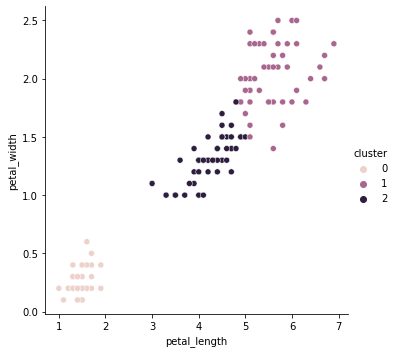

In [16]:
sns.relplot(data = iris, x = "petal_length", y ="petal_width", hue = "cluster")
plt.plot()

#### c. Use the elbow method to visually select a good value for k.

Text(0.5, 1.0, 'change in inertia as k increase')

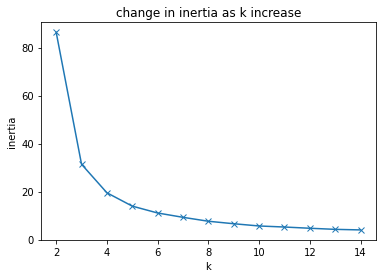

In [23]:
pd.Series({k:KMeans(k).fit(X).inertia_ for k in range(2,15)}).plot(marker = "x")
plt.xlabel("k")
plt.ylabel("inertia")
plt.title("change in inertia as k increase")

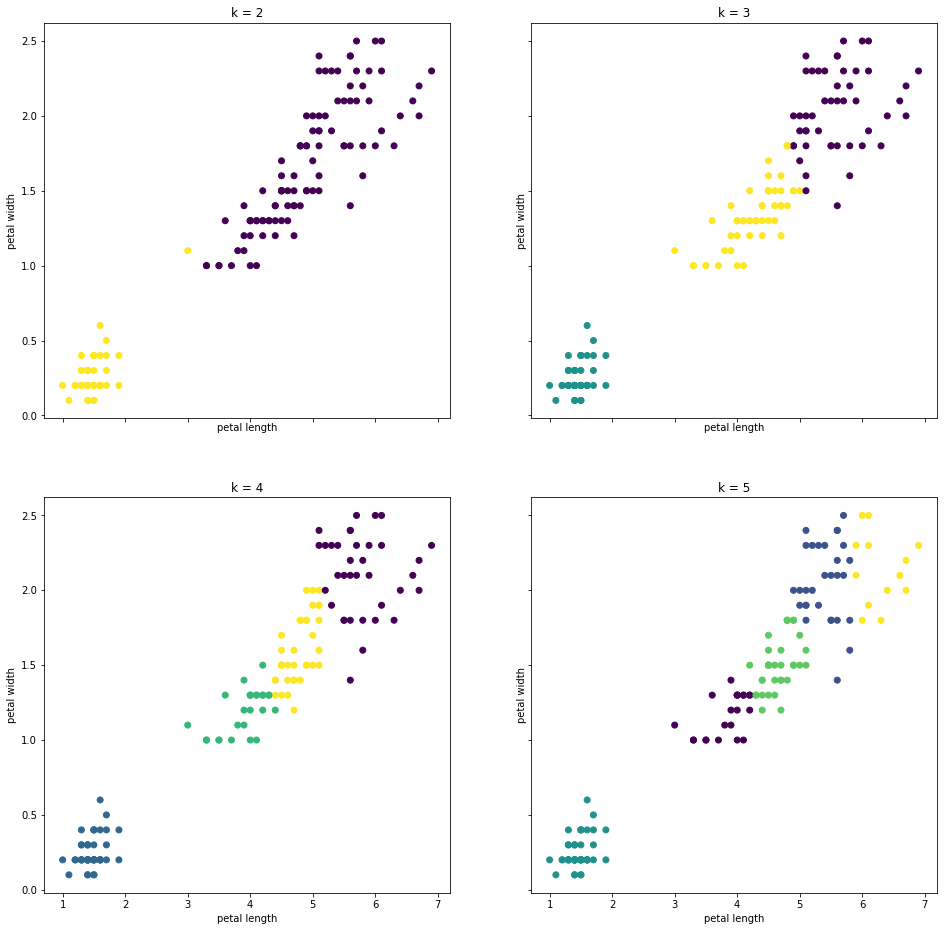

In [31]:
fig, axs = plt.subplots(2, 2, figsize=(16, 16), sharex=True, sharey=True)

for ax, k in zip(axs.ravel(), range(2, 6)):
    clusters = KMeans(k).fit(X).predict(X)
    ax.scatter(X.petal_length, X.petal_width, c=clusters)
    ax.set(title='k = {}'.format(k), xlabel='petal length', ylabel='petal width')


In [30]:
#seems like good value for k = 4

#### d. Repeat the clustering, this time with 3 different features.


In [40]:
X = iris[['sepal_length','sepal_width', 'petal_length']]

In [41]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

kmeans.predict(X)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2], dtype=int32)

<AxesSubplot:>

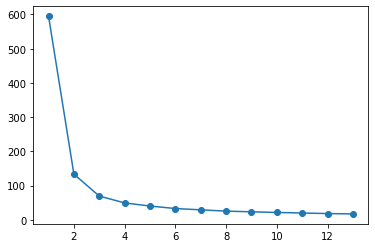

In [47]:
pd.Series({k:KMeans(k).fit(X).inertia_ for k in range(1,14)}).plot(marker = "o")

In [49]:
iris['cluster1'] =kmeans.predict(X)
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species,cluster,cluster1
0,5.1,3.5,1.4,0.2,setosa,0,1
1,4.9,3.0,1.4,0.2,setosa,0,1
2,4.7,3.2,1.3,0.2,setosa,0,1
3,4.6,3.1,1.5,0.2,setosa,0,1
4,5.0,3.6,1.4,0.2,setosa,0,1


[]

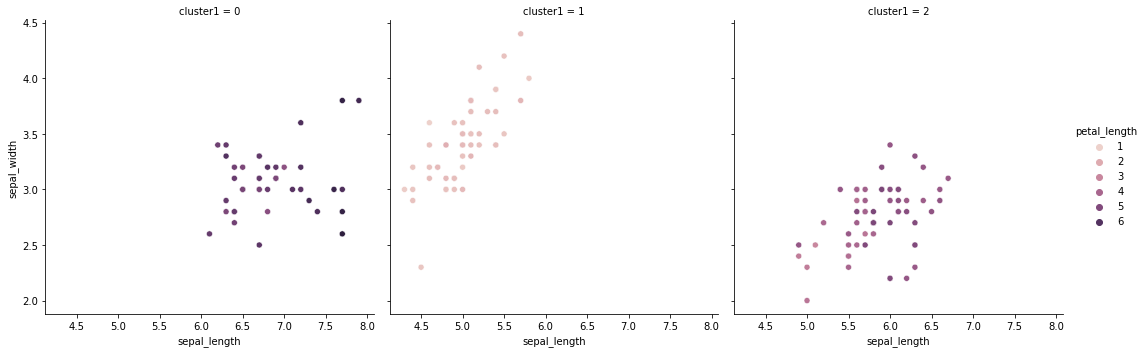

In [53]:
sns.relplot(data=iris, x = "sepal_length", y = "sepal_width", hue = 'petal_length', col = "cluster1")
plt.plot()